<a href="https://colab.research.google.com/github/JakubCzech/Interns2020/blob/master/AE_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
   Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x
def denoising_autoencoder():
   dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(dae_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)


   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)

   final_deconv = Conv2DTranspose(filters=3,
                                 kernel_size=3,
                                  padding='same')(deconv_block4)

   dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)

   return Model(dae_inputs, dae_outputs, name='dae')

In [3]:

# ładowanie bazy
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data()
# konwersja na float
train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.
# dodanie szumów
train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)
# trenowanie modelu
dae = denoising_autoencoder()
dae.compile(loss='mse', optimizer='adam')

checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)


dae.fit(train_data_noisy,
       train_data_clean,
       validation_data=(test_data_noisy, test_data_clean),epochs=40,batch_size=128,callbacks=[checkpoint])
dae.load_weights('best_model.h5')
test_data_denoised = dae.predict(test_data_noisy)


170500096/170498071 [==============================] - 6s 0us/step
Epoch 1/40
391/391 [==============================] - ETA: 0s - loss: 0.0042
Epoch 00001: val_loss improved from inf to 0.00580, saving model to best_model.h5
391/391 [==============================] - 9s 24ms/step - loss: 0.0042 - val_loss: 0.0058
Epoch 2/40
391/391 [==============================] - ETA: 0s - loss: 0.0024
Epoch 00002: val_loss improved from 0.00580 to 0.00226, saving model to best_model.h5
391/391 [==============================] - 9s 22ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 3/40
391/391 [==============================] - ETA: 0s - loss: 0.0022
Epoch 00003: val_loss improved from 0.00226 to 0.00211, saving model to best_model.h5
391/391 [==============================] - 9s 22ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 4/40
391/391 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00004: val_loss improved from 0.00211 to 0.00189, saving model to best_model.h5
391/391 [======

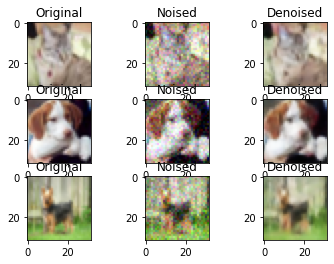

In [5]:

idx = 8
plt.subplot(3,3,1)
plt.imshow(test_data_clean[idx])
plt.title('Original')
plt.subplot(3,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('Noised')
plt.subplot(3,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('Denoised')

plt.subplot(3,3,4)
plt.imshow(test_data_clean[idx*2])
plt.title('Original')
plt.subplot(3,3,5)
plt.imshow(test_data_noisy[idx*2])
plt.title('Noised')
plt.subplot(3,3,6)
plt.imshow(test_data_denoised[idx*2])
plt.title('Denoised')

plt.subplot(3,3,7)
plt.imshow(test_data_clean[idx*3])
plt.title('Original')
plt.subplot(3,3,8)
plt.imshow(test_data_noisy[idx*3])
plt.title('Noised')
plt.subplot(3,3,9)
plt.imshow(test_data_denoised[idx*3])
plt.title('Denoised')
plt.show()